# Трекинг и подсчет пешеходов на видео

Требуется реализовать подсчет людей на видеопоследовательности.

В качестве результатов необходимо:
- Показать код с запуском трекера и логикой подсчета людей.
- Визуализировать видео с подсчетом людей (показать треки и bounding boxes).

Импортируем все требуемые зависимости

In [1]:
import math
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import cv2
from ultralytics import YOLO

Установим нужные пакеты

In [2]:
!python3 -m pip install ultralytics  --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


Используем предобученную модель YOLO v8

In [3]:
model = YOLO("yolov8n.pt")

Объявим функцию для генерации данных трекинга для входной видеопоследовательности

- в цикле считываем изображения покадрово
- детектируем и персистентно трекаем объекты на изображениях
- ограничиваем список классов только пешеходами

In [4]:
def track(video_path):
    cap = cv2.VideoCapture(video_path)

    track_history = defaultdict(lambda: [])

    while cap.isOpened():
        success, frame = cap.read()

        if success:
            results = model.track(frame, persist=True, classes=0, verbose=False)
        
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()

            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y)))
        else:
            break

    cap.release()
    
    return results, track_history

Объявим функцию для отображения результатов трекинга

- отображаем bounding boxes
- отображаем траектории движения людей

In [5]:
def visualize_tracking_result(result, track_history):
    boxes = result.boxes.xywh.cpu()
    track_ids = result.boxes.id.int().cpu().tolist()
    annotated_frame = result.plot()
    
    for box, track_id in zip(boxes, track_ids):
        x, y, w, h = box
        track = track_history[track_id]
        track.append((float(x), float(y)))

        points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)

    plt.imshow(annotated_frame)
    plt.show()    

### Датасет 1

Взглянем на результат детектирования для первого видео

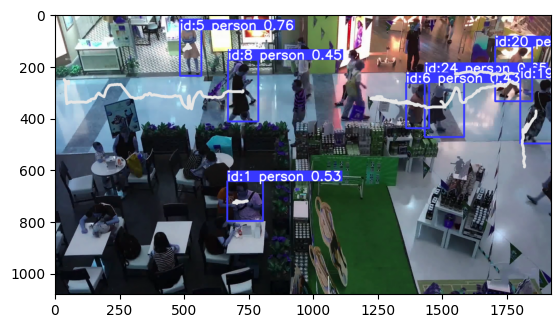

Количество распознанных пешеходов: 19


In [6]:
results_1, track_history_1 = track("1.mp4")
visualize_tracking_result(results_1[0], track_history_1)
print('Количество распознанных пешеходов:', len(track_history_1))

### Датасет 3

Взглянем на результат детектирования для второго видео

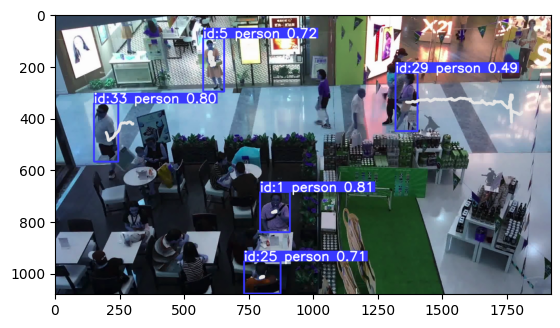

Количество распознанных пешеходов: 10


In [7]:
results_3, track_history_3 = track("3.mp4")
visualize_tracking_result(results_3[0], track_history_3)
print('Количество распознанных пешеходов:', len(track_history_3))

### Датасет 96

Взглянем на результат детектирования для третьего видео

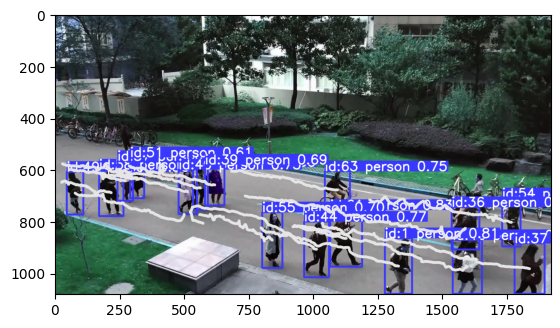

Количество распознанных пешеходов: 26


In [8]:
results_96, track_history_96 = track("96.mp4")
visualize_tracking_result(results_96[0], track_history_96)
print('Количество распознанных пешеходов:', len(track_history_96))

## Тепловые карты движения

Работа вышла совсем короткой, поэтому дополнительно отобразим тепловые карты движения (выдернул из своего старого [пет-проекта](https://habr.com/ru/articles/718106/))

Вначале объявим функции для проективного преобразования точек траекторий так как плоскость движения пешеходов ориентирована относительно камеры определенным образом

In [9]:
IMAGE_H = 1080
IMAGE_W = 1920

src = np.float32([[0, 0], [IMAGE_W, 0], [0, IMAGE_H], [IMAGE_W, IMAGE_H]])
dst = np.float32([[550, 0], [IMAGE_W-550, 0], [0, IMAGE_H], [IMAGE_W, IMAGE_H]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def trasnformPoint(p):
    px = (M[0][0]*p[0] + M[0][1]*p[1] + M[0][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
    py = (M[1][0]*p[0] + M[1][1]*p[1] + M[1][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
    return (int(px), int(py))

def trasnformPointInv(p):
    px = (Minv[0][0]*p[0] + Minv[0][1]*p[1] + Minv[0][2]) / ((Minv[2][0]*p[0] + Minv[2][1]*p[1] + Minv[2][2]))
    py = (Minv[1][0]*p[0] + Minv[1][1]*p[1] + Minv[1][2]) / ((Minv[2][0]*p[0] + Minv[2][1]*p[1] + Minv[2][2]))
    return (int(px), int(py))

def get_bounds():
    left_top = trasnformPointInv((0,0))
    right_top = trasnformPointInv((IMAGE_W,0))
    left_bottom = trasnformPointInv((0,IMAGE_H))
    right_bottom = trasnformPointInv((IMAGE_W,IMAGE_H))
    return (
        np.min([left_top[0], left_bottom[0]]),
        np.min([left_top[1], right_top[1]]),
        np.max([right_top[0], right_bottom[0]]),
        np.max([left_bottom[1], right_bottom[1]])
    )

Посмотрим как это выглядит, нанеся импровизированную координатную сетку

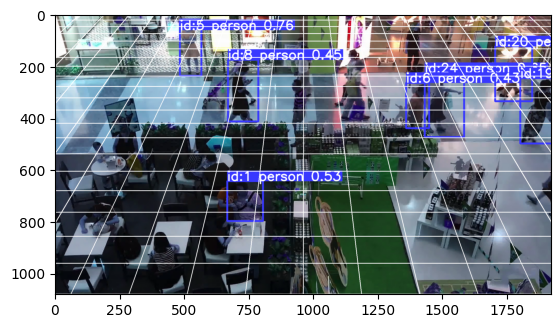

In [10]:
annotated_frame = results_1[0].plot()

GRID_SIZE = 20

min_x, min_y, max_x, max_y = get_bounds()

step_x = (max_x - min_x) / GRID_SIZE
step_y = (max_y - min_y) / GRID_SIZE

x = min_x
y = min_y

while x <= max_x:
    cv2.line(annotated_frame, trasnformPoint((x, min_y)), trasnformPoint((x, max_y)), (255,255,255), 2)
    x += step_x

while y <= max_y:
    cv2.line(annotated_frame, trasnformPoint((min_x, y)), trasnformPoint((max_x, y)), (255,255,255), 2)
    y += step_y
    
plt.imshow(annotated_frame)
plt.show()    

Объявим класс для тепловой карты, который будет накапливать данные о движении поклеточно

In [11]:
class HeatMap:
    def __init__(self, size):
        self.mat = [[0 for _ in range(size)] for _ in range(size)]
        self.max_len = 0

    def set(self, i, j, value):
        item = self.mat[i][j]
        if item == 0:
            item = {'average': 0, 'data': []}
        item['data'].append(value)
        item['average'] = np.average(item['data'])
        self.max_len = max(self.max_len, len(item['data']))
        self.mat[i][j] = item

    def get(self, i, j):
        return self.mat[i][j]

Объявим функции, необходимые для визуализации тепловой карты движения

- приведение скорости движения к цвету
- отрисовка полигонов заданного цвета и прозрачности

Прозрачность характеризует плотность, а "зеленость" - скорость движения в заданной клетке

In [12]:
def number_to_color(num, max):
    fromR = 255
    fromG = 0
    fromB = 0

    toR = 0
    toG = 255
    toB = 0

    deltaR = round((toR - fromR) / max)
    deltaG = round((toG - fromG) / max)
    deltaB = round((toB - fromB) / max)

    R = fromR + num * deltaR
    G = fromG + num * deltaG
    B = fromB + num * deltaB

    return (R, G, B)

def fill_poly_alpha(img, points, color, alpha):
    overlay = img.copy()
    cv2.fillPoly(overlay, np.int32([points]), color)
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

Идем по точкам траекторий и сохраняем данные о скорости движения в конкретных координатных клетках

In [13]:
heatmap = HeatMap(GRID_SIZE)

for track in track_history_1.values():
    for ind in range(len(track) - 1):
        x_cur, y_cur = trasnformPointInv(track[ind])
        x_next, y_next = trasnformPointInv(track[ind + 1])
        diff = math.sqrt(pow(x_next - x_cur, 2) + pow(y_next - y_cur, 2))
        i, j = (int((x_next - min_x)/step_x), int((y_next - min_y)/step_y))
        heatmap.set(i, j, diff)

Отрисовывем полученные данные 

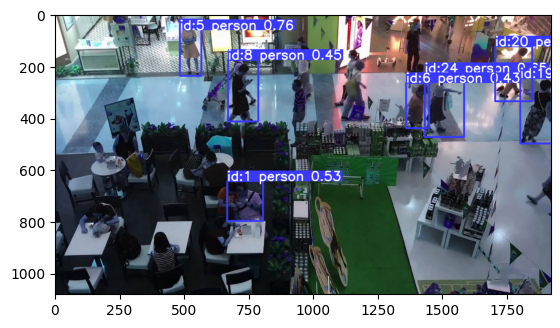

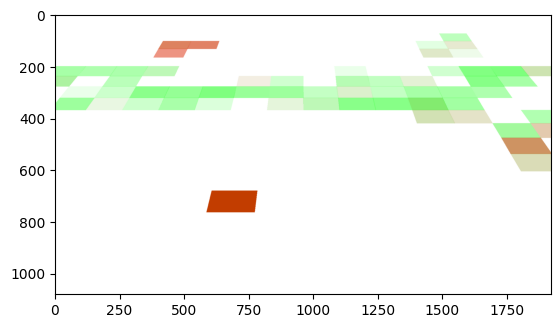

In [14]:
annotated_frame = results_1[0].plot()
plt.imshow(annotated_frame)
plt.show() 

annotated_frame.fill(255)

for j in range(GRID_SIZE):
    for i in range(GRID_SIZE):
        item = heatmap.get(i, j)
        if item != 0:
            t_l = trasnformPoint([min_x + int(i * step_x), min_y + int(j * step_y)])
            t_r = trasnformPoint([min_x + int(i * step_x) + int(step_x), min_y + int(j * step_y)])
            b_l = trasnformPoint([min_x + int(i * step_x), min_y + int(j * step_y) + int(step_y)])
            b_r = trasnformPoint([min_x + int(i * step_x) + int(step_x), min_y + int(j * step_y) + int(step_y)])
            points = np.array([t_l, t_r, b_r, b_l])
            color = number_to_color(item['average'], 10)
            alpha = math.sqrt(len(item['data']) / heatmap.max_len)
            fill_poly_alpha(annotated_frame, np.int32([points]), color, alpha)
            
plt.imshow(annotated_frame)
plt.show()  

Сделаем то же самое для датасета 96, обновив матрицы проекции (так как камера висит иначе относительно плоскости земли)

In [30]:
src = np.float32([[0, 0], [IMAGE_W, 0], [0, IMAGE_H], [IMAGE_W, IMAGE_H]])
dst = np.float32([[750, 0], [IMAGE_W-750, 0], [0, IMAGE_H], [IMAGE_W, IMAGE_H]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

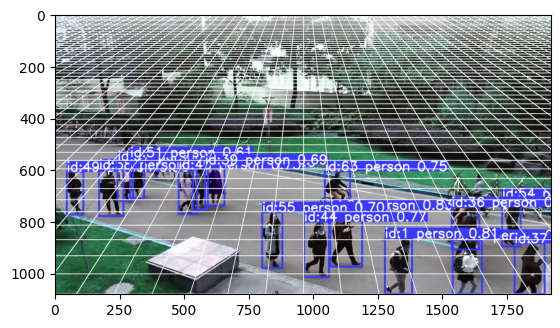

In [33]:
annotated_frame = results_96[0].plot()

GRID_SIZE = 60

min_x, min_y, max_x, max_y = get_bounds()

step_x = (max_x - min_x) / GRID_SIZE
step_y = (max_y - min_y) / GRID_SIZE

x = min_x
y = min_y

while x <= max_x:
    cv2.line(annotated_frame, trasnformPoint((x, min_y)), trasnformPoint((x, max_y)), (255,255,255), 2)
    x += step_x

while y <= max_y:
    cv2.line(annotated_frame, trasnformPoint((min_x, y)), trasnformPoint((max_x, y)), (255,255,255), 2)
    y += step_y
    
plt.imshow(annotated_frame)
plt.show()    

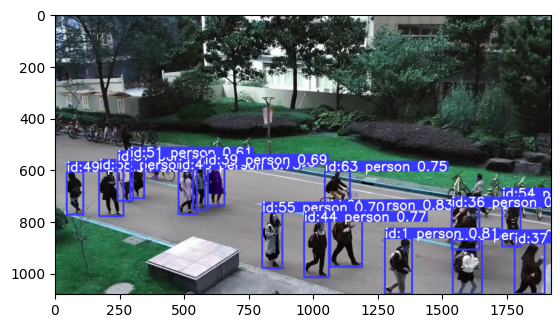

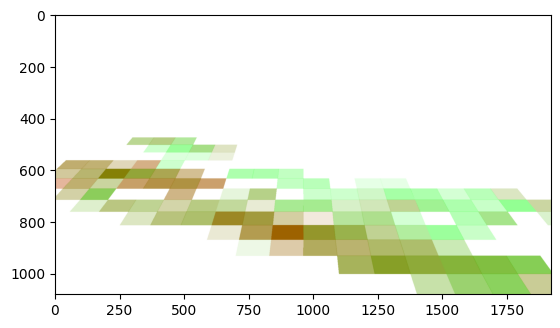

In [34]:
heatmap = HeatMap(GRID_SIZE)

for track in track_history_96.values():
    for ind in range(len(track) - 1):
        x_cur, y_cur = trasnformPointInv(track[ind])
        x_next, y_next = trasnformPointInv(track[ind + 1])
        diff = math.sqrt(pow(x_next - x_cur, 2) + pow(y_next - y_cur, 2))
        i, j = (int((x_next - min_x)/step_x), int((y_next - min_y)/step_y))
        heatmap.set(i, j, diff)
        
annotated_frame = results_96[0].plot()
plt.imshow(annotated_frame)
plt.show() 

annotated_frame.fill(255)

for j in range(GRID_SIZE):
    for i in range(GRID_SIZE):
        item = heatmap.get(i, j)
        if item != 0:
            t_l = trasnformPoint([min_x + int(i * step_x), min_y + int(j * step_y)])
            t_r = trasnformPoint([min_x + int(i * step_x) + int(step_x), min_y + int(j * step_y)])
            b_l = trasnformPoint([min_x + int(i * step_x), min_y + int(j * step_y) + int(step_y)])
            b_r = trasnformPoint([min_x + int(i * step_x) + int(step_x), min_y + int(j * step_y) + int(step_y)])
            points = np.array([t_l, t_r, b_r, b_l])
            color = number_to_color(item['average'], 10)
            alpha = math.sqrt(len(item['data']) / heatmap.max_len)
            fill_poly_alpha(annotated_frame, np.int32([points]), color, alpha)
            
plt.imshow(annotated_frame)
plt.show()  